# This notebook contains:
* Precipitation roses: using the BARRA-2 850 hPa wind fields (to determine regime)
* Plots wind roses for 850hPa winds over the CBS
* Plots of wind regime frequency (stacked bar plots) over the CBS
* Convert time to LST

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import SubplotDivider, Size
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import windrose 
from windrose import WindroseAxes 
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap

# BARRA-2 Winds: wind roses

In [5]:
def file_paths(variable):
    list = ["202201-202201","202202-202202","202203-202203"]#,"202204-202204"]
    # list = ["202201-202201","202202-202202","202203-202203","202204-202204","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
    #        "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
    #        "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
    #        "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
    #        "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
    #        "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+variable+"/v20231001/"
        all_files = [fp+variable+"_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  
ua850 = file_paths("ua850") # in m/s
va850 = file_paths("va850") # in m/s
tas = file_paths("tasmean")
sfc_sw_up = file_paths("rsus")
sfc_sw_dw = file_paths("rsds")
uasfc = file_paths("uasmean")
vasfc = file_paths("vasmean")

In [4]:
def get_file_paths(directory,fn1,fn2): # for all barra-2 years available (1979-2023)
    """
    Returns a list of all file paths within a directory.
    
    Args:
    - directory (str): The directory path.
    
    Returns:
    - file_paths (list): List of file paths within the directory.
    """
    file_paths = []
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        # Iterate through files
        for file in files:
            # Construct the file path
            file_path = os.path.join(root, file)
            # Append the file path to the list
            file_paths.append(file_path)
    file_paths.sort()
    months_cbs = []
    for i in range(len(file_paths)):
        if file_paths[i][fn1:fn2] in ["01", "02", "03", "04"]:
            months_cbs.append(file_paths[i])
        else:
            pass
    return months_cbs
ua850 = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/ua850/v20231001/",167,169) # in m/s
va850 = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/va850/v20231001/",167,169) # in m/s
uasfc = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/uasmean/v20231001/",171,173)
vasfc = get_file_paths("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/vasmean/v20231001/",171,173)

In [38]:
# surface- station obs
def open_and_calc_mean(file_path,variable):#.sel(time=slice('2022-01-01T00:00:00.000000000','2022-04-30T23:00:00.000000000'))
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        # towns = ds[variable].sel(lat=-19.2483,lon=146.7661,method='nearest')
        cairns = ds[variable].sel(lat=-16.9,method='nearest').sel(lon=slice(143,152))        # adjusting lat lon so that is a land point          
        return (cairns*units("m/s")).compute() #(towns*units("m/s")).compute(),
uuC = open_and_calc_mean(ua850,"ua850")
vvC = open_and_calc_mean(va850,"va850")

In [4]:
def open_and_calc_mean(file_path,variable):#.sel(time=slice('2022-01-01T00:00:00.000000000','2022-04-30T23:00:00.000000000'))
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        towns = ds[variable].sel(lat=slice(-20.768799,-18.0708),lon=slice(145.12054,147.9812)).mean(dim=["lat","lon"])
        cairns = ds[variable].sel(lat=slice(-18.165955,-15.468018),lon=slice(144.27374,147.09222)).mean(dim=["lat","lon"])                  
        willis = ds[variable].sel(lat=slice(-17.636353,-14.938416),lon=slice(148.55927,151.36993)).mean(dim=["lat","lon"])
        return (towns*units("m/s")).compute(),(cairns*units("m/s")).compute(),(willis*units("m/s")).compute() 
uuT,uuC,uuW = open_and_calc_mean(ua850,"ua850")
vvT,vvC,vvW = open_and_calc_mean(va850,"va850")

In [22]:
def open_and_calc_hovmoller(file_path,variable,unit):#.sel(time=slice('2022-01-01T00:00:00.000000000','2022-04-30T23:00:00.000000000'))
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        towns = ds[variable].sel(lat=-19.4198,method="nearest").sel(lon=slice(143,152))
        cairns = ds[variable].sel(lat=-16.8736,method="nearest").sel(lon=slice(143,152))                
        willis = ds[variable].sel(lat=-16.2874,method="nearest").sel(lon=slice(143,152))
        return (towns*units(unit)).compute(),(cairns*units(unit)).compute(),(willis*units(unit)).compute() 
# uuT,uuC,uuW = open_and_calc_hovmoller(ua850,"ua850","m/s")
# vvT,vvC,vvW = open_and_calc_hovmoller(va850,"va850","m/s")
# sfc_tempT, sfc_tempC,sfc_tempW = open_and_calc_hovmoller(tas,"tasmean","K") 
# sfc_SW_upT, sfc_SW_upC,sfc_SW_upW = open_and_calc_hovmoller(sfc_sw_up,"rsus","W m-2") 
# sfc_SW_dwT, sfc_SW_dwC,sfc_SW_dwW = open_and_calc_hovmoller(sfc_sw_dw,"rsds","W m-2") 
uuT,uuC,uuW = open_and_calc_hovmoller(uasfc,"uasmean","m/s")
vvT,vvC,vvW = open_and_calc_hovmoller(vasfc,"vasmean","m/s")

In [91]:
net_SW = sfc_SW_dwC - sfc_SW_upC

In [5]:
towns_wind_dir = metpy.calc.wind_direction(uuT,vvT,convention='from')
towns_wind_speed = metpy.calc.wind_speed(uuT,vvT)
cairns_wind_dir = metpy.calc.wind_direction(uuC,vvC,convention='from')
cairns_wind_speed = metpy.calc.wind_speed(uuC,vvC)
willis_wind_dir850 = metpy.calc.wind_direction(uuW,vvW,convention='from')
willis_wind_speed850 = metpy.calc.wind_speed(uuW,vvW)

In [6]:
def wind_times(winds):    
    ne = winds[(winds>=0*units("degrees"))&(winds<=90*units("degrees"))].time.values
    se = winds[(winds>90*units("degrees"))&(winds<=180*units("degrees"))].time.values
    sw = winds[(winds>180*units("degrees"))&(winds<=270*units("degrees"))].time.values
    nw = winds[(winds>270*units("degrees"))&(winds<=360*units("degrees"))].time.values
    return ne,se,sw,nw
ne,se,sw,nw = wind_times(cairns_wind_dir)

In [120]:
def wind_regime_stats(wind_regime_ds,wind_speed_ds):
    ne = wind_regime_ds[(wind_regime_ds>=0*units("degrees"))&(wind_regime_ds<=90*units("degrees"))]
    se = wind_regime_ds[(wind_regime_ds>90*units("degrees"))&(wind_regime_ds<=180*units("degrees"))]
    sw = wind_regime_ds[(wind_regime_ds>180*units("degrees"))&(wind_regime_ds<=270*units("degrees"))]
    nw = wind_regime_ds[(wind_regime_ds>270*units("degrees"))&(wind_regime_ds<=360*units("degrees"))]
    print('Values are printed in order: N-E, S-E, S-W, N-w')
    # return wind_speed_ds.sel(time=ne.time.values,method="nearest").drop_duplicates('time').std(),wind_speed_ds.sel(time=se.time.values,method="nearest").drop_duplicates('time').std(),wind_speed_ds.sel(time=sw.time.values,method="nearest").drop_duplicates('time').std(),wind_speed_ds.sel(time=nw.time.values,method="nearest").drop_duplicates('time').std()
    return len(wind_speed_ds.sel(time=ne.time.values,method="nearest").drop_duplicates('time').time),len(wind_speed_ds.sel(time=se.time.values,method="nearest").drop_duplicates('time').time),len(wind_speed_ds.sel(time=sw.time.values,method="nearest").drop_duplicates('time').time),len(wind_speed_ds.sel(time=nw.time.values,method="nearest").drop_duplicates('time').time)

In [123]:
wind_regime_stats(cairns_wind_dir,cairns_wind_speed.drop_vars('pressure'))

Values are printed in order: N-E, S-E, S-W, N-w


(18701, 87223, 12499, 11441)

# Look at wind stats

In [56]:
# open station dataset
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")
# Selecting for station IDs, select and add units to variables
townsville_wdir = station_ds.wdir.sel(station=30) * units("degrees")
townsville_wspd = (station_ds.wspd.sel(station=30) * (1000/(60*60))) *  units("m/s")
# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# townsville variables
wdirT = JFMA_data(townsville_wdir)
wspdT = JFMA_data(townsville_wspd)
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskT,wspd_maskT = wind_masks(wdirT,wspdT)
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)

In [225]:
# look at percentage of calm periods
len(towns_wind_speed)
calm = towns_wind_speed[towns_wind_speed<0.5*units("m/s")]
len(calm)/len(towns_wind_speed)*100

0.6999630382554056

In [216]:
# calc mean wind dir
from scipy.stats import circmean
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
print('Mean Townsville wind direction: ',calc_mean_wdir(towns_wind_dir))
print('Mean Cairns wind direction: ',calc_mean_wdir(cairns_wind_dir))

Mean Townsville wind direction:  96.63495704975665
Mean Cairns wind direction:  135.04239972969444


In [223]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
def round_to_nearest_tens(x):
    return np.round(x / 10) * 10
    
def rmse(ds_barra,ds_obs,wind_dir=None):
    # Assuming y_true and y_pred are your true and predicted values, respectively
    barra = ds_barra.sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000'))
    true = ds_obs.sel(time=barra.time.values)
    data_array_without_nan = true.dropna(dim='time')
    pred = barra.sel(time=data_array_without_nan.time.values)
    # Calculate Mean Squared Error (MSE)
    if wind_dir==True:
        # account for circular nature of the data
        radian_pred = np.deg2rad(pred)
        radian_true = np.deg2rad(data_array_without_nan)
        # Compute circular difference
        diff_rad = np.arctan2(np.sin(radian_true - radian_pred), np.cos(radian_true - radian_pred))
        # Convert back to degrees
        diff_deg = np.degrees(diff_rad)
        # Calculate mean squared error
        mse = np.mean(diff_deg ** 2)
    else:
        mse = mean_squared_error(data_array_without_nan,pred)
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    return rmse
# rmse(towns_wind_speed,wspd_maskT,wind_dir=False)
rmse(cairns_wind_speed,wspd_maskC,wind_dir=False)
# rmse(towns_wind_dir,wdir_maskT,wind_dir=True)
# rmse(cairns_wind_dir,wdir_maskC,wind_dir=True)

2.4652369997496093

In [218]:
# percentage of times that BARRA-2 is within 45 degrees of obs
def angle_between_barra_obs(barra, obs):
    dot = np.cos(barra)*np.cos(obs) + np.sin(barra)*np.sin(obs)
    angle = np.arccos(dot)
    return angle <= np.pi/4
    
barra = cairns_wind_dir.sel(time=slice('1990-01-01T00:00:00.000000000','2020-02-01T00:00:00.000000000'))
true = wdir_maskC.sel(time=barra.time.values)

data_array_without_nan = true.dropna(dim='time')
pred = barra.sel(time=data_array_without_nan.time.values)
result = angle_between_barra_obs(pred, data_array_without_nan)[angle_between_barra_obs(pred, data_array_without_nan)==True]
len(result)/len(pred)*100

71.06869738448685

# Plot wind rose

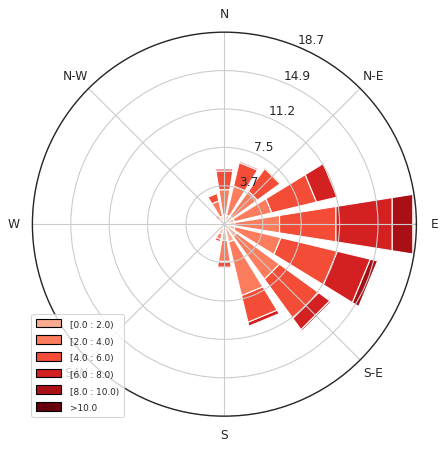

In [231]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
sns.set_theme(style="white")

orig_map = plt.cm.get_cmap('Reds')
cmap_range_start = 0.3
cmap_range_end = 1.0
cmap_colors = orig_map(np.linspace(cmap_range_start, cmap_range_end, 256))
cmap_reds_custom_custom = LinearSegmentedColormap.from_list("RedsCustom", cmap_colors)
ax = WindroseAxes.from_ax(figsize=(6,15))
bars = ax.bar(towns_wind_dir, towns_wind_speed, normed=True,bins=[0,2,4,6,8,10],nsector=16,opening=0.8,edgecolor='white', 
              cmap=cmap_reds_custom_custom) # 3,6,9,12,15
# ax.set_title("Cairns BARRA-2 Surface Winds",fontsize=20,pad=15)
ax.set_legend();
# plt.colorbar(bars)

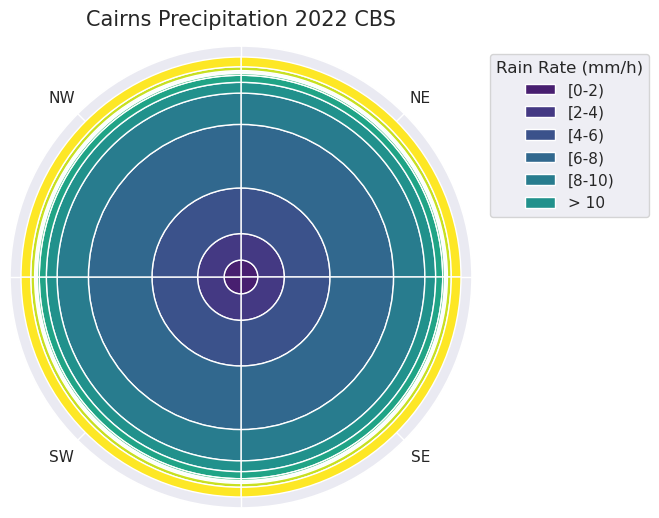

In [61]:
def stacked_bar_polar_plot(data,category,bins):
    # create plot
    fig = plt.figure(figsize=(8,6))
    sns.set_theme(style="dark")
    ax = fig.add_subplot(111,polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # pie slices
    angles = [0, 1/2*np.pi,1*np.pi,6/4*np.pi]
    # width of slices (depends on wind regimes - how the wind bins are created)
    width = [1/2*np.pi]
    
    # stack bars
    bottom = np.zeros(len(angles))
    colors = plt.cm.get_cmap("viridis",len(bins))
    for i in range(len(data)):
        ax.bar(angles,data[i],width=width,bottom=bottom,color=colors(i+1),align="edge")
        bottom +=data[i]
    
    # set group labels
    custom_labels = ["",'NE',"",'SE',"", 'SW',"",'NW']
    theta = [0.0,(1/4) * np.pi,(2/4) * np.pi,(3/4) * np.pi,(4/4) * np.pi,(5/4) * np.pi,(6/4) * np.pi,(7/4) * np.pi]
    ax.set_xticks(theta)
    ax.set_xticklabels(custom_labels)
    yticks = np.arange(0,100,20)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['0%',"2%","4%","6%","8%"])
    # set title
    ax.set_title("Cairns Precipitation 2022 CBS",fontsize=15,pad=15) #"Cairns 2022 CBS Raining Periods"

    # set legend
    ax.legend(bbox_to_anchor=(1.4, 1),title="Rain Rate (mm/h)",
              labels=[category[0],category[1],category[2],category[3],category[4],category[5]],
             )
    plt.show()
wind = ["[0-2)","[2-4)","[4-6)","[6-8)","[8-10)","> 10"]
stacked_bar_polar_plot(freq_percentage,wind,direction_bins)

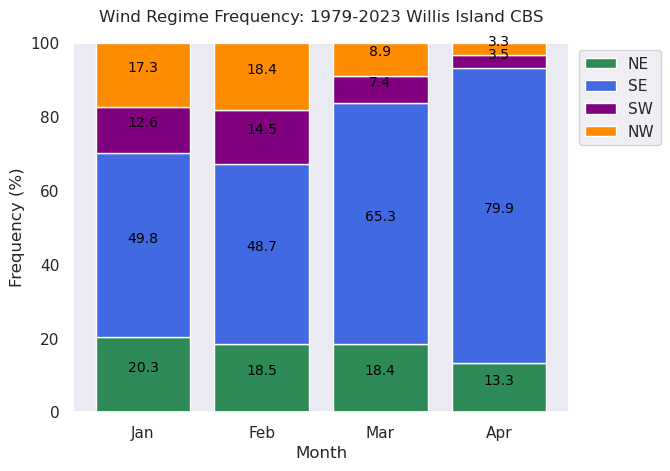

In [78]:
# plot frequency of winds per month
months = willis_wind_dir.groupby(willis_wind_dir.time.dt.month)
def wind_counts(winds):
    ne = (winds[(winds>0*units("degrees"))&(winds<=90*units("degrees"))].count()/len(winds))*100
    se = (winds[(winds>90*units("degrees"))&(winds<=180*units("degrees"))].count()/len(winds))*100
    sw = (winds[(winds>180*units("degrees"))&(winds<=270*units("degrees"))].count()/len(winds))*100
    nw = (winds[(winds>270*units("degrees"))&(winds<=360*units("degrees"))].count()/len(winds))*100
    return ne,se,sw,nw
jne,jse,jsw,jnw = wind_counts(months[1])
fne,fse,fsw,fnw = wind_counts(months[2])
mne,mse,msw,mnw = wind_counts(months[3])
ane,ase,asw,anw = wind_counts(months[4])
categories = ["Jan","Feb","Mar","Apr"]

values1 = [jne.values,fne.values,mne.values,ane.values]
values2 = [jse.values,fse.values,mse.values,ase.values]
values3 = [jsw.values,fsw.values,msw.values,asw.values]
values4 = [jnw.values,fnw.values,mnw.values,anw.values]

# Create the first bar plot
sns.set_theme(style="dark")
plt.bar(categories, values1, label='NE',color='seagreen')
plt.bar(categories, values2, bottom=values1, label='SE',color='royalblue')
plt.bar(categories, values3, bottom=[i+j for i, j in zip(values1, values2)], label='SW',color='purple')
plt.bar(categories, values4, bottom=[i+j+k for i, j, k in zip(values1, values2, values3)], label='NW',color='darkorange')
# add text labels for each stacked bar
for i, (v1, v2, v3, v4) in enumerate(zip(values1, values2, values3, values4)):
    plt.text(i, v1- v1/ 2, f'{v1:.1f}', color="black", ha='center', va='bottom',fontsize=10)
    plt.text(i, (v1+v2)-v2/2, f'{v2:.1f}', color="black", ha='center', va='bottom',fontsize=10)
    plt.text(i, (v1+v2+v3)-v3/2, f'{v3:.1f}', color="black", ha='center', va='bottom',fontsize=10)
    plt.text(i, (v1+v2+v3+v4)-v4/2, f'{v4:.1f}', color="black", ha='center', va='bottom',fontsize=10)
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylabel('Frequency (%)')
plt.xlabel('Month')
plt.title('Wind Regime Frequency: 1979-2023 Willis Island CBS',pad=15);

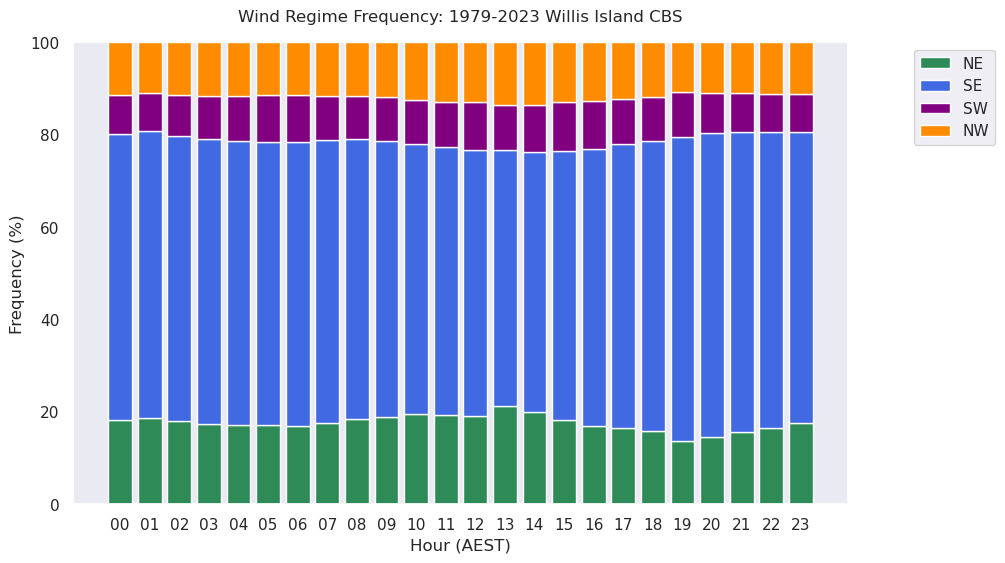

In [81]:
# plot frequency of winds per hour
hours = willis_wind_dir.groupby(willis_wind_dir.time.dt.hour)
def wind_counts(winds):
    ne = (winds[(winds>0*units("degrees"))&(winds<=90*units("degrees"))].count()/len(winds))*100
    se = (winds[(winds>90*units("degrees"))&(winds<=180*units("degrees"))].count()/len(winds))*100
    sw = (winds[(winds>180*units("degrees"))&(winds<=270*units("degrees"))].count()/len(winds))*100
    nw = (winds[(winds>270*units("degrees"))&(winds<=360*units("degrees"))].count()/len(winds))*100
    return ne,se,sw,nw
ne = []
se = []
sw = []
nw = []
for hour in np.arange(0,24,1):
    NE,SE,SW,NW = wind_counts(hours[hour])
    ne.append(NE)
    se.append(SE)
    sw.append(SW)
    nw.append(NW)
categories = ["00","01","02","03","04","05","06","07","08","09","10","11",
              "12","13","14","15","16","17","18","19","20","21","22","23"]

# Create the first bar plot
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
sns.set_theme(style="dark")
ax.bar(categories, np.roll(ne,shift=10), label='NE',color='seagreen')
ax.bar(categories, np.roll(se,shift=10), bottom=np.roll(ne,shift=10), label='SE',color='royalblue')
ax.bar(categories, np.roll(sw,shift=10), bottom=[i+j for i, j in zip(np.roll(ne,shift=10), np.roll(se,shift=10))], label='SW',color='purple')
ax.bar(categories, np.roll(nw,shift=10), bottom=[i+j+k for i, j, k in zip(np.roll(ne,shift=10), np.roll(se,shift=10), np.roll(sw,shift=10))], label='NW',color='darkorange')
ax.set_ylim(0, 100)
plt.legend(bbox_to_anchor=(1.2, 1))
ax.set_ylabel('Frequency (%)')
ax.set_xlabel('Hour (AEST)')
ax.set_title('Wind Regime Frequency: 1979-2023 Willis Island CBS',pad=15);

In [39]:
import datetime
import pytz
from datetime import datetime, timedelta
# Convert time to pandas datetime objects
time_values = pd.to_datetime(uuC['time'].values,unit='ns')

# Define the longitude of the location (in degrees)
longitude = 145.6 # Cairns

# Convert nanoseconds to datetime objects in UTC
time_objects_utc = pd.to_datetime(time_values, unit='ns')

# Define the time zone for the location
local_timezone = pytz.timezone('Australia/Sydney')

# Convert UTC datetime objects to the local time zone
time_objects_local = time_objects_utc.tz_localize('UTC').tz_convert(local_timezone)

# Calculate the offset from UTC based on the longitude
# 4 minutes per degree of longitude from the prime meridian
longitude_offset = timedelta(minutes=(longitude / 360) * 60)

# Adjust the time to local solar time based on the longitude offset
time_objects_solar = time_objects_local - longitude_offset

# Format datetime objects as strings
time_strings_solar = time_objects_solar.strftime("%m-%dT%H")

In [40]:
# update time in ds to local solar time
uuC['time'] = time_strings_solar

In [41]:
uuC

Magnitude,[[2.578125 2.640625 2.828125 ... 6.90625 7.07421875 7.296875] [3.39453125 3.39453125 3.31640625 ... 6.78515625 6.90625 7.05859375] [3.578125 3.62890625 3.578125 ... 6.55859375 6.6953125 6.875] ... [-0.93359375 -0.04296875 0.51953125 ... 0.875 1.51171875 2.0] [-1.65625 -1.1640625 -0.359375 ... -0.35546875 0.359375 1.046875] [-1.3984375 -0.73046875 -0.1171875 ... -0.359375 0.078125 0.49609375]]
Units,meter/second


In [ ]:
uuC

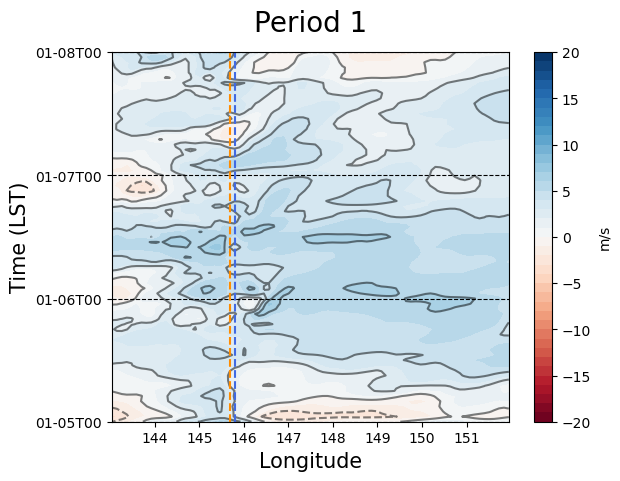

In [45]:
x = uuC.isel(time=0).lon.values
sliced = slice('01-04T23:00:00.000000000','01-08T00:00:00.000000000')
y = uuC.time.sel(time=sliced) #-16.817 #-19.4198
z = uuC.sel(time=sliced) # latitude is for the central Townsville radar site location
levels = np.arange(-20,21,1)
# levels=np.arange(0,390,30)
cf = plt.contourf(x,y,z,levels=levels,cmap="RdBu")#"tab20")
levelsc = np.arange(-20,22,2)
# levelsc=np.arange(0,390,30)
c = plt.contour(x,y,z,levels=levelsc,colors="black",alpha=0.5,linewidth=0.5,cmap=None)
cb = plt.colorbar(cf)
cb.set_label('m/s')
plt.axvline(145.683,color='darkorange',linestyle='--')
plt.axvline(145.8,color='royalblue',alpha=1,linestyle='--')
plt.title('Period 1',fontsize=20,pad=15)#Cairns: 850 hPa U Winds Hovmöller Diagram')
plt.xlabel("Longitude",fontsize=15)
plt.grid(axis="y",color="black",linestyle='--',alpha=1)
plt.ylabel('Time (LST)',fontsize=15)
yticks = np.arange(0,len(uuC.time.sel(time=sliced)),24)
plt.yticks(yticks)
plt.grid(axis="y",color="black",linestyle='--',alpha=1)


# Mask Radar Rain Rate

In [65]:
def path_to_radar_ds(radar_site_no,variable):
    """
    List of yyyymm (year+month) with available radar data.
    For each yyyymm create a list of entire file paths to netCDF4 files.

    Parameters:
    - radar_site_no (str): Radar site number- BoM ID's for radar locations: Townsville=73, Cairns=19, and Willis Island=41 

    Returns:
    - list: list object of netCDF4 files
    """
    list = ["202112","202201","202202","202203","202204",
           "202205","202206","202207","202208","202209",
           "202210","202211","202212",
           "202301","202302","202303","202304",
           "202305","202306","202307","202308","202309",
           "202310","202311","202312"] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/"+variable+"/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list
cairns_radar_files = path_to_radar_ds("19","RAINRATE")
townsville_radar_files = path_to_radar_ds("73","REFLECTIVITY")
townsville_radar_filesrr = path_to_radar_ds("73","RAINRATE")

In [66]:
def open_radar(file_path,variable):
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        nan_to_zero = ds[variable].fillna(0) # creates a much lower mean threshold (if used for masking) - includes non raining periods
        return ds
rr = open_radar(cairns_radar_files,"rainrate")
reflectivity = open_radar(townsville_radar_files,"reflectivity")
rr_towns = open_radar(townsville_radar_filesrr,"rainrate")

In [67]:
def mask_radar(file_path,threshold): 
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:
        condition1 = ~ds.rainrate.mean(dim='time').isnull()
        ds_mean = ds.rainrate.mean(dim='time')
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean))
        condition2 = masked_beam_blockage.astype(bool)
        mask = condition1 & condition2
        return mask
# rr_masked = mask_radar(cairns_radar_files,0.75)
rr_masked = mask_radar(townsville_radar_filesrr,0.75)

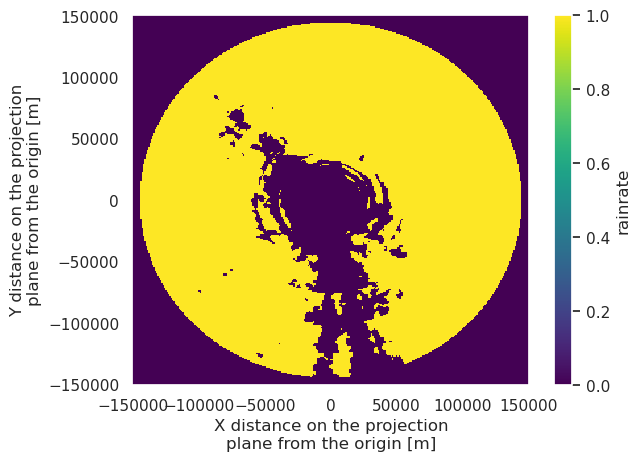

In [68]:
rr_masked.plot()

In [44]:
mask = reflectivity.where(rr_masked)

In [31]:
mask

<xarray.Dataset> Size: 46GB
Dimensions:       (time: 25632, y: 301, x: 301)
Coordinates:
  * x             (x) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * y             (y) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * time          (time) datetime64[ns] 205kB 2022-02-01 ... 2022-04-30T23:55:00
Data variables:
    reflectivity  (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    longitude     (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    latitude      (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    isfile        (time, y, x) float64 19GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
Attributes: (12/57)
    summary:                       Level 2 dataset from the Australian radar ...
    history:                       created by Joshua Soderholm on gadi.nci.or...
    acknowledgement:               This work is support by the Bureau of Mete...
    institution:                   Bureau of Meteorology
    keywords:                      radar, Doppler, dual-polarization
    licence:                       CC4.0-BY-NC (if the latest dataset licence...
    ...                            ...
    geospatial_vertical_min:       2500
    geospatial_vertical_max:       2500
    comments:                      Radar reflectivity has not been corrected ...
    geospatial_projection:         Azimuthal equidistant projection
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m

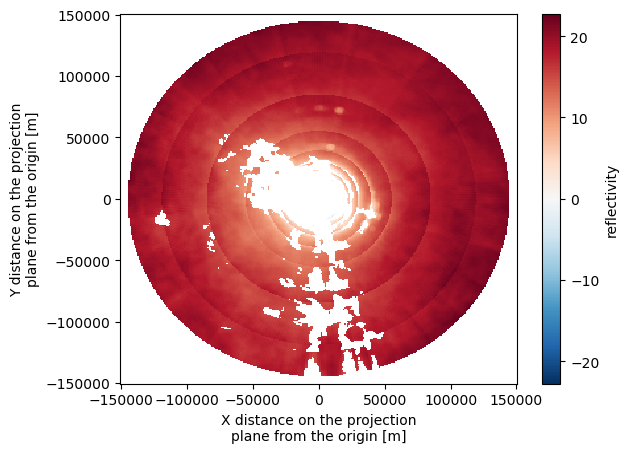

In [24]:
mask.reflectivity.mean(dim="time").plot()

In [12]:
case_study_jam_fp = "/home/563/ac9768/himawari_regridded_files/case-study_ch13BT_00UTC-01-01-2022_23UTC-31-03-2022.nc"
case_study_jam = xr.open_dataset(case_study_jam_fp,engine="h5netcdf", chunks="auto")

In [14]:
def wind_regime(winds):
    e = winds[(winds>0*units("degrees"))&(winds<=180*units("degrees"))].time.values
    w = winds[(winds>180*units("degrees"))&(winds<=360*units("degrees"))].time.values
    return e,w
easterlies, westerlies = wind_regime(cairns_wind_dir)

In [129]:
bt_easterlies = case_study_jam.sel(lat=-16.82,time=easterlies,method="nearest").drop_duplicates(dim='time')
bt_westerlies = case_study_jam.sel(lat=-16.82,time=westerlies,method="nearest").drop_duplicates(dim='time')

In [130]:
e_bt_hour = bt_easterlies.ch13BT.groupby(bt_easterlies.time.dt.hour).mean("time").compute()
w_bt_hour = bt_westerlies.ch13BT.groupby(bt_westerlies.time.dt.hour).mean("time").compute()

In [35]:
# select radar data slices +30min/-30min from the hour - dependent on regime
def radar_regimes(regime,minutes,ds):
    selected_data = []
    window_size = pd.Timedelta(minutes=minutes)
    # Loop through each time point in wind regime
    for time in regime: 
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        data_within_window = ds.sel(time=slice(window_start, window_end))
        # Append the selected data to the list
        selected_data.append(data_within_window)
    select_regime = xr.concat(selected_data, dim='time')
    return select_regime
rr_easterlies = radar_regimes(easterlies,30,mask)
rr_westerlies = radar_regimes(westerlies,30,mask)

In [141]:
e_rr_hour = rr_easterlies.isel(y=slice(130,170)).groupby(rr_easterlies.time.dt.hour).mean(dim=["time","y"]).compute()
w_rr_hour = rr_westerlies.isel(y=slice(130,170)).groupby(rr_westerlies.time.dt.hour).mean(dim=["time","y"]).compute()

In [196]:
len(bt_westerlies.time)

735

In [204]:
len(rr.latitude.isel(y=slice(130,170))[0])

40

In [165]:
w_bt_hour.max()

<xarray.DataArray 'ch13BT' ()> Size: 8B
array(295.94573975)
Coordinates:
    lat      float64 8B -16.82

In [147]:
e_bt_hour.min()

<xarray.DataArray 'ch13BT' ()> Size: 8B
array(258.67330933)
Coordinates:
    lat      float64 8B -16.82

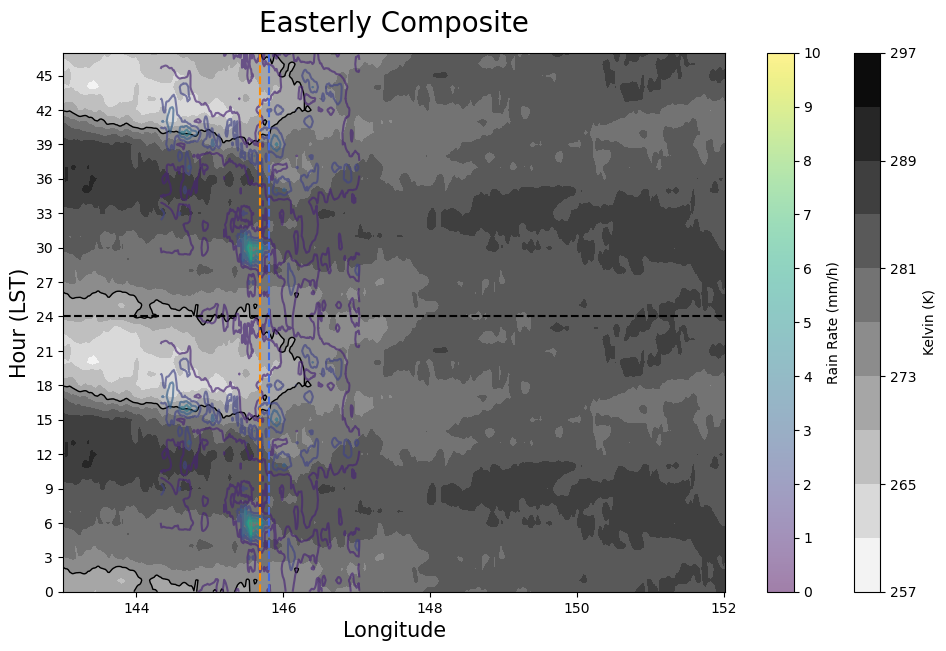

In [191]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
fig.patch.set_facecolor('white')
levels=np.arange(257,300,4)
cf = ax.contourf(e_bt_hour.lon.values,np.arange(0,48,1),np.concatenate([np.roll(e_bt_hour,shift=10,axis=0),np.roll(e_bt_hour,shift=10,axis=0)]),levels=levels,cmap="binary")
c1 = ax.contour(e_bt_hour.lon.values,np.arange(0,48,1),np.concatenate([np.roll(e_bt_hour,shift=10,axis=0),np.roll(e_bt_hour,shift=10,axis=0)]),levels=[273],colors="black",linewidths=1)
cairns_radar_lon = rr.longitude.isel(y=150).values
levelsc = np.arange(0,11,1)
c = ax.contour(cairns_radar_lon[0],np.arange(0,48,1),np.concatenate([np.roll(e_rr_hour,shift=10,axis=0),np.roll(e_rr_hour,shift=10,axis=0)]),levels=levelsc,cmap="viridis",alpha=0.65)
plt.colorbar(cf,label="Kelvin (K)",pad=-0.04)
ax.axvline(145.683,color='darkorange',linestyle='--')
ax.axvline(145.8,color='royalblue',alpha=1,linestyle='--')
# ax.axhline(12,color='black',linestyle='--')
ax.axhline(24,color='black',linestyle='--')
# ax.axhline(36,color='black',linestyle='--')
norm= matplotlib.colors.Normalize(vmin=c.cvalues.min(), vmax=c.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = c.cmap)
sm.set_array([])
plt.colorbar(sm,label="Rain Rate (mm/h)",ticks=c.levels,ax=ax,alpha=0.5)
ax.set_title("Easterly Composite",pad=15,fontsize=20)
ax.set_ylabel("Hour (LST)",fontsize=15)
ax.set_xlabel("Longitude",fontsize=15)
yticks=np.arange(0,48,3)
ax.set_yticks(yticks);

# Plot rain rate hovmoller

In [28]:
# convert time variables from UTC to to LST
import datetime
import pytz
from datetime import datetime, timedelta
# Convert time to pandas datetime objects
time_values1 = pd.to_datetime(rr['time'].values,unit='ns')
time_values2 = pd.to_datetime(mask['time'].values,unit='ns')

# Define the longitude of the location (in degrees)
longitude = 145.6 # Cairns

# Convert nanoseconds to datetime objects in UTC
time_objects_utc1 = pd.to_datetime(time_values1, unit='ns')
time_objects_utc2 = pd.to_datetime(time_values2, unit='ns')

# Define the time zone for the location
local_timezone = pytz.timezone('Australia/Sydney')

# Convert UTC datetime objects to the local time zone
time_objects_local1 = time_objects_utc1.tz_localize('UTC').tz_convert(local_timezone)
time_objects_local2 = time_objects_utc2.tz_localize('UTC').tz_convert(local_timezone)

# Calculate the offset from UTC based on the longitude
# 4 minutes per degree of longitude from the prime meridian
longitude_offset = timedelta(minutes=(longitude / 360) * 60)

# Adjust the time to local solar time based on the longitude offset
time_objects_solar1 = time_objects_local1 - longitude_offset
time_objects_solar2 = time_objects_local2 - longitude_offset

# Format datetime objects as strings
time_strings_solar1 = time_objects_solar1.strftime("%m-%dT%H:%M")
time_strings_solar2 = time_objects_solar2.strftime("%m-%dT%H:%M")

In [29]:
# update time in ds to local solar time
mask['time'] = time_strings_solar1
# mask['time'] = time_strings_solar2

In [35]:
mask

<xarray.Dataset> Size: 46GB
Dimensions:       (time: 25632, y: 301, x: 301)
Coordinates:
  * x             (x) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * y             (y) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
  * time          (time) datetime64[ns] 205kB 2022-02-01 ... 2022-04-30T23:55:00
Data variables:
    reflectivity  (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    longitude     (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    latitude      (time, y, x) float32 9GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
    isfile        (time, y, x) float64 19GB dask.array<chunksize=(288, 301, 301), meta=np.ndarray>
Attributes: (12/57)
    summary:                       Level 2 dataset from the Australian radar ...
    history:                       created by Joshua Soderholm on gadi.nci.or...
    acknowledgement:               This work is support by the Bureau of Mete...
    institution:                   Bureau of Meteorology
    keywords:                      radar, Doppler, dual-polarization
    licence:                       CC4.0-BY-NC (if the latest dataset licence...
    ...                            ...
    geospatial_vertical_min:       2500
    geospatial_vertical_max:       2500
    comments:                      Radar reflectivity has not been corrected ...
    geospatial_projection:         Azimuthal equidistant projection
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m

In [53]:
time.stop 
# time.start
len(rr_towns.time.sel(time=time).values)

579

In [57]:
mask.reflectivity.sel(time=time).isel(y=150)

<xarray.DataArray 'reflectivity' (time: 579, x: 301)> Size: 697kB
dask.array<getitem, shape=(579, 301), dtype=float32, chunksize=(288, 301), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 1kB -150000 -149000 -148000 ... 148000 149000 150000
    y        int32 4B 0
  * time     (time) datetime64[ns] 5kB 2021-12-25T11:55:00 ... 2021-12-27T12:...
Attributes:
    least_significant_digit:  1
    long_name:                reflectivity
    units:                    dBZ
    description:              equivalent reflectivity factor at an altitude o...
    comments:                 
    valid_min:                -32.0
    valid_max:                80.0

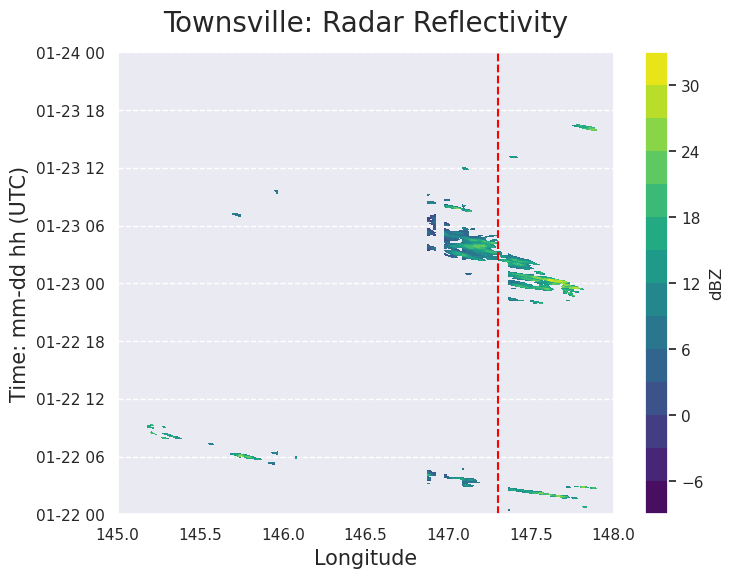

In [60]:
# hovmoller rain rate
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="dark")
ax = plt.subplot(1, 1, 1,)
time = slice('2022-01-22T00:00:00.000000000','2022-01-24T00:00:00.000000000')
x = rr_towns.longitude.isel(time=0,y=150).values
y = rr_towns.time.sel(time=time).values
z = mask.reflectivity.sel(time=time).isel(y=150)
levels = [0,0.5,1,2,4,456]
colors = ['#084594', '#4292c6', 'seagreen','#addd8e', '#f7fcb9','pink','red']
cf = ax.contourf(x,y,z,levels=15,cmap="viridis")#colors=colors)
cb = plt.colorbar(cf,ax=ax)
cb.set_label("dBZ")#mm/h")
xtick = np.arange(145,148.5,0.5)
ax.set_xticks(xtick)
# ytick = np.arange(0,len(rr_towns.time.sel(time=time).values),1)
# ax.set_yticks(ytick)
ax.axvline(147.3,linestyle='--',color='red')
ax.set_xlabel('Longitude',fontsize=15)
ax.set_ylabel('Time: mm-dd hh (UTC)',fontsize=15)
ax.grid(axis="y",linestyle='--')
ax.grid(axis="x", visible=False)
ax.set_title('Townsville: Radar Reflectivity',fontsize=20,pad=15);

# Plot snapshots of rain rate

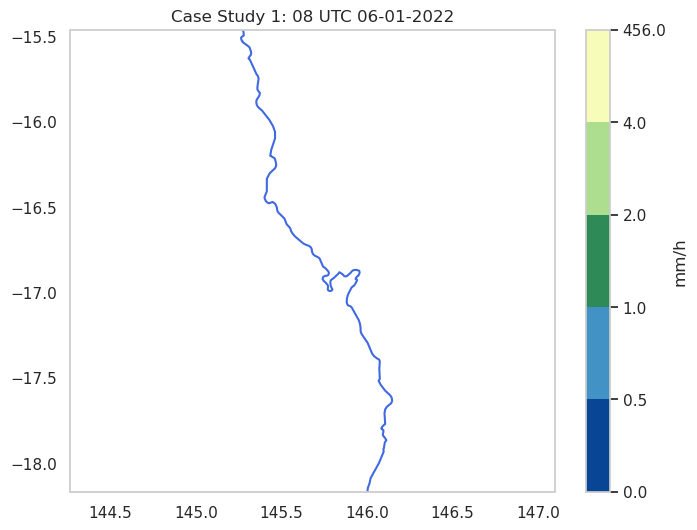

In [23]:
# plot single times
fig = plt.figure(figsize=(8,6))
fig.tight_layout()
fig.patch.set_facecolor('white')
sns.set_theme(style="whitegrid")
projPC = ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=projPC)
time = slice('2022-01-06T07:30:00.000000000','2022-01-06T08:30:00.000000000')
x = rr.longitude.isel(time=0).values
y = rr.latitude.isel(time=0).values
z = mask.sel(time=time).mean('time')
levels = [0,0.5,1,2,4,456]
colors = ['#084594', '#4292c6', 'seagreen','#addd8e', '#f7fcb9','pink','red']
cf = ax.contourf(x,y,z,levels=levels,colors=colors)
cb = plt.colorbar(cf,ax=ax)
cb.set_label("mm/h")
xtick = np.arange(144.5,147.5,0.5)
ax.set_xticks(xtick)
ytick = np.arange(-18,-15,0.5)
ax.set_yticks(ytick)
ax.coastlines("10m",color="royalblue",linewidth=1.5)
ax.grid(None)
ax.set_title('Case Study 1: 08 UTC 06-01-2022');

# Plot Precipitation Roses

In [17]:
# define the times when winds originate from a direction (wind regimes)
def wind_times(winds):    
    ne = winds[(winds>=0*units("degrees"))&(winds<=90*units("degrees"))].time.values
    se = winds[(winds>90*units("degrees"))&(winds<=180*units("degrees"))].time.values
    sw = winds[(winds>180*units("degrees"))&(winds<=270*units("degrees"))].time.values
    nw = winds[(winds>270*units("degrees"))&(winds<=360*units("degrees"))].time.values
    return ne,se,sw,nw
ne,se,sw,nw = wind_times(cairns_wind_dir)

In [19]:
# select radar data slices +30min/-30min from the hour - dependent on regime
def radar_regimes(regime,minutes,ds):
    selected_data = []
    window_size = pd.Timedelta(minutes=minutes)
    # Loop through each time point in wind regime
    for time in regime: 
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        data_within_window = ds.sel(time=slice(window_start, window_end))
        # Append the selected data to the list
        selected_data.append(data_within_window)
    select_regime = xr.concat(selected_data, dim='time')
    return select_regime
mask = rr.rainrate.where(rr_masked)
ne_radar = radar_regimes(ne,30,mask)
se_radar = radar_regimes(se,30,mask)
sw_radar = radar_regimes(sw,30,mask)
nw_radar = radar_regimes(nw,30,mask)

In [81]:
# create histogram based on rainrate bins
bins = [0.1, 0.5, 1, 2, 4, 8 ]  # rain rate precision is to .1, so therefore >0 must have a bin minimum of 0.1 mm/h
# Convert ne_radar to a numpy array
ne_radar_array = ne_radar.values
se_radar_array = se_radar.values
sw_radar_array = sw_radar.values
nw_radar_array = nw_radar.values
# Compute the histogram
nehist, bin_edges = np.histogram(ne_radar_array, bins=bins)
sehist, bin_edges = np.histogram(se_radar_array, bins=bins)
swhist, bin_edges = np.histogram(sw_radar_array, bins=bins)
nwhist, bin_edges = np.histogram(nw_radar_array, bins=bins)

In [82]:
def hist_freq(ne,se,sw,nw,masked_radar):
    freq_raining = []
    freq_alltimes = []
    total_raining_sum = ne.sum() + se.sum() + sw.sum() + nw.sum()
    points_sum = np.abs(~np.isnan(mask.mean('time')).sum().values) #90601-36723: total - nan regions
    total = points_sum*len(mask)
    for i in np.arange(0,5,1):
        freq_raining.append([[ne[i]/total_raining_sum * 100],[se[i]/total_raining_sum * 100],[sw[i]/total_raining_sum * 100],[nw[i]/total_raining_sum * 100]])
        freq_alltimes.append([[ne[i]/total * 100],[se[i]/total * 100],[sw[i]/total * 100],[nw[i]/total * 100]])  
    return freq_raining,freq_alltimes
hist_raining,hist_all = hist_freq(nehist,sehist,swhist,nwhist,mask)
hist_raining_array = np.array(hist_raining)
hist_all_array = np.array(hist_all)
hist_raining_reshape = hist_raining_array.reshape(5,4)
hist_all_reshape = hist_all_array.reshape(5,4)

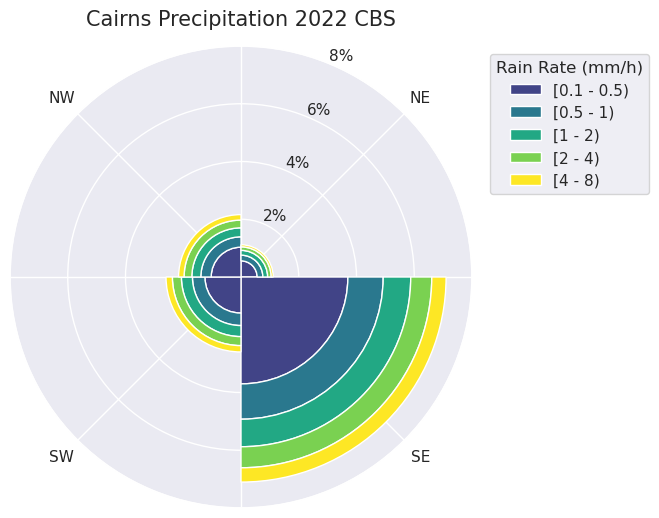

In [115]:
# define polar plot to show precipitation rose
def stacked_bar_polar_plot(data,rr_category,bins):
    # create plot
    fig = plt.figure(figsize=(8,6))
    sns.set_theme(style="dark")
    ax = fig.add_subplot(111,polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    # pie slices
    angles = [0, 1/2*np.pi,1*np.pi,6/4*np.pi]
    # width of slices (depends on wind regimes - how the wind bins are created)
    width = [1/2*np.pi]
    
    # stack bars
    bottom = np.zeros(len(angles))
    colors = plt.cm.get_cmap("viridis",len(bins))
    for i in range(len(data)):
        ax.bar(angles,data[i],width=width,bottom=bottom,color=colors(i+1),align="edge")
        bottom +=data[i]
    
    # set group labels
    custom_labels = ["",'NE',"",'SE',"", 'SW',"",'NW']
    theta = [0.0,(1/4) * np.pi,(2/4) * np.pi,(3/4) * np.pi,(4/4) * np.pi,(5/4) * np.pi,(6/4) * np.pi,(7/4) * np.pi]
    ax.set_xticks(theta)
    ax.set_xticklabels(custom_labels)
    yticks = np.arange(0,10,2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['0%',"2%","4%","6%","8%"])
    # set title
    ax.set_title("Cairns Precipitation 2022 CBS",fontsize=15,pad=15) #"Cairns 2022 CBS Raining Periods"

    # set legend
    ax.legend(bbox_to_anchor=(1.4, 1),title="Rain Rate (mm/h)",
              labels=[rr_values[0],rr_values[1],rr_values[2],rr_values[3],rr_values[4],rr_values[5]],
             )
    plt.show()
rr_values = ["[0.1 - 0.5)","[0.5 - 1)","[1 - 2)","[2 - 4)","[4 - 8)","> 8"]
stacked_bar_polar_plot(hist_all_reshape,rr_values,bins)